# Parameter variation
Goal is to see how much binary parameters can vary but still result in stacked transits.

In [1]:
import copy
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import astropy.units as u
import funcs

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# Kepler 34


cb = funcs.CBSystem(m1 = 1.0479,f1 = 1.,m2 = 1.0208,f2 = 0.8475,
                    ab = 0.22882,r1 = 1.1618 * u.Rsun.to('au'),r2 = 1.0927 * u.Rsun.to('au'),
                    eb = 0.52087,ib = np.deg2rad(89.8584),wb = 1.2468,
                    fb = 3.4675,
                    mp = 0.220 * u.Mjup.to('Msun'),ap = 1.0896,rp = 0.764 * u.Rjupiter.to('au'),ep = 0.182,
                    ip = np.deg2rad(90.355),wp = 0.1378,fp = 2.0623,
                    Wp = np.deg2rad(-1.74),
                    t0 = 2454969.2000)
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days

print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)
print(p_p0)

timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi

27.7960087219
288.8298729659465


In [4]:
# make our reference light curve, with no eclipses/occultations
dt = 0.02
t = np.arange(2454953,2456424,dt)

f_pl = funcs.pd_cb(cb, times=t)
tmp = cb.rp
cb.rp = 0.0
f_nopl = funcs.pd_cb(cb, times=t)
cb.rp = tmp
f_ref = f_pl / f_nopl

1.23 s ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


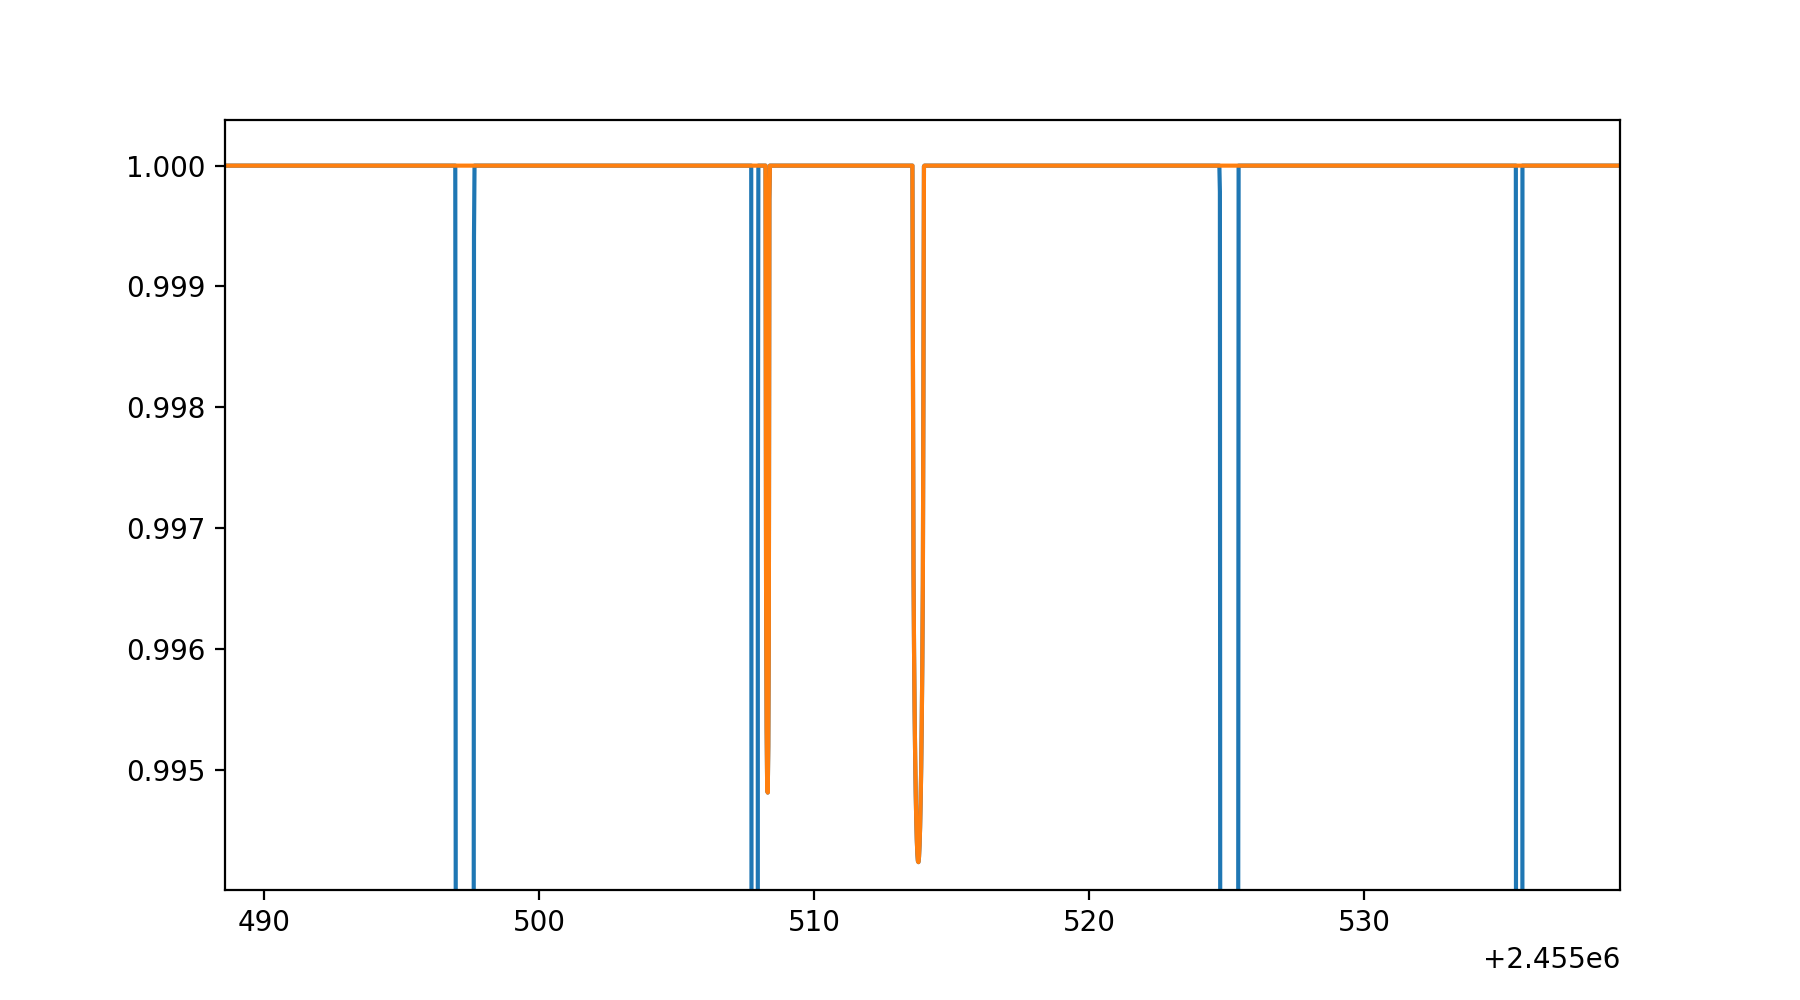

In [38]:
fig,ax = plt.subplots(figsize=(9,5))
ax.plot(t,f_pl)
ax.plot(t,f_ref)

In [39]:
%timeit funcs.reb_cb(cb,tmin=np.min(t),tmax=np.max(t))
#%timeit funcs.pd_cb(cb, times=t)
%timeit funcs.reb_cb_dvm(cb, 0, 2, tmin=np.min(t), tmax=np.max(t), timing_precision=timing_precision)
#%timeit funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))

236 ms ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80.6 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


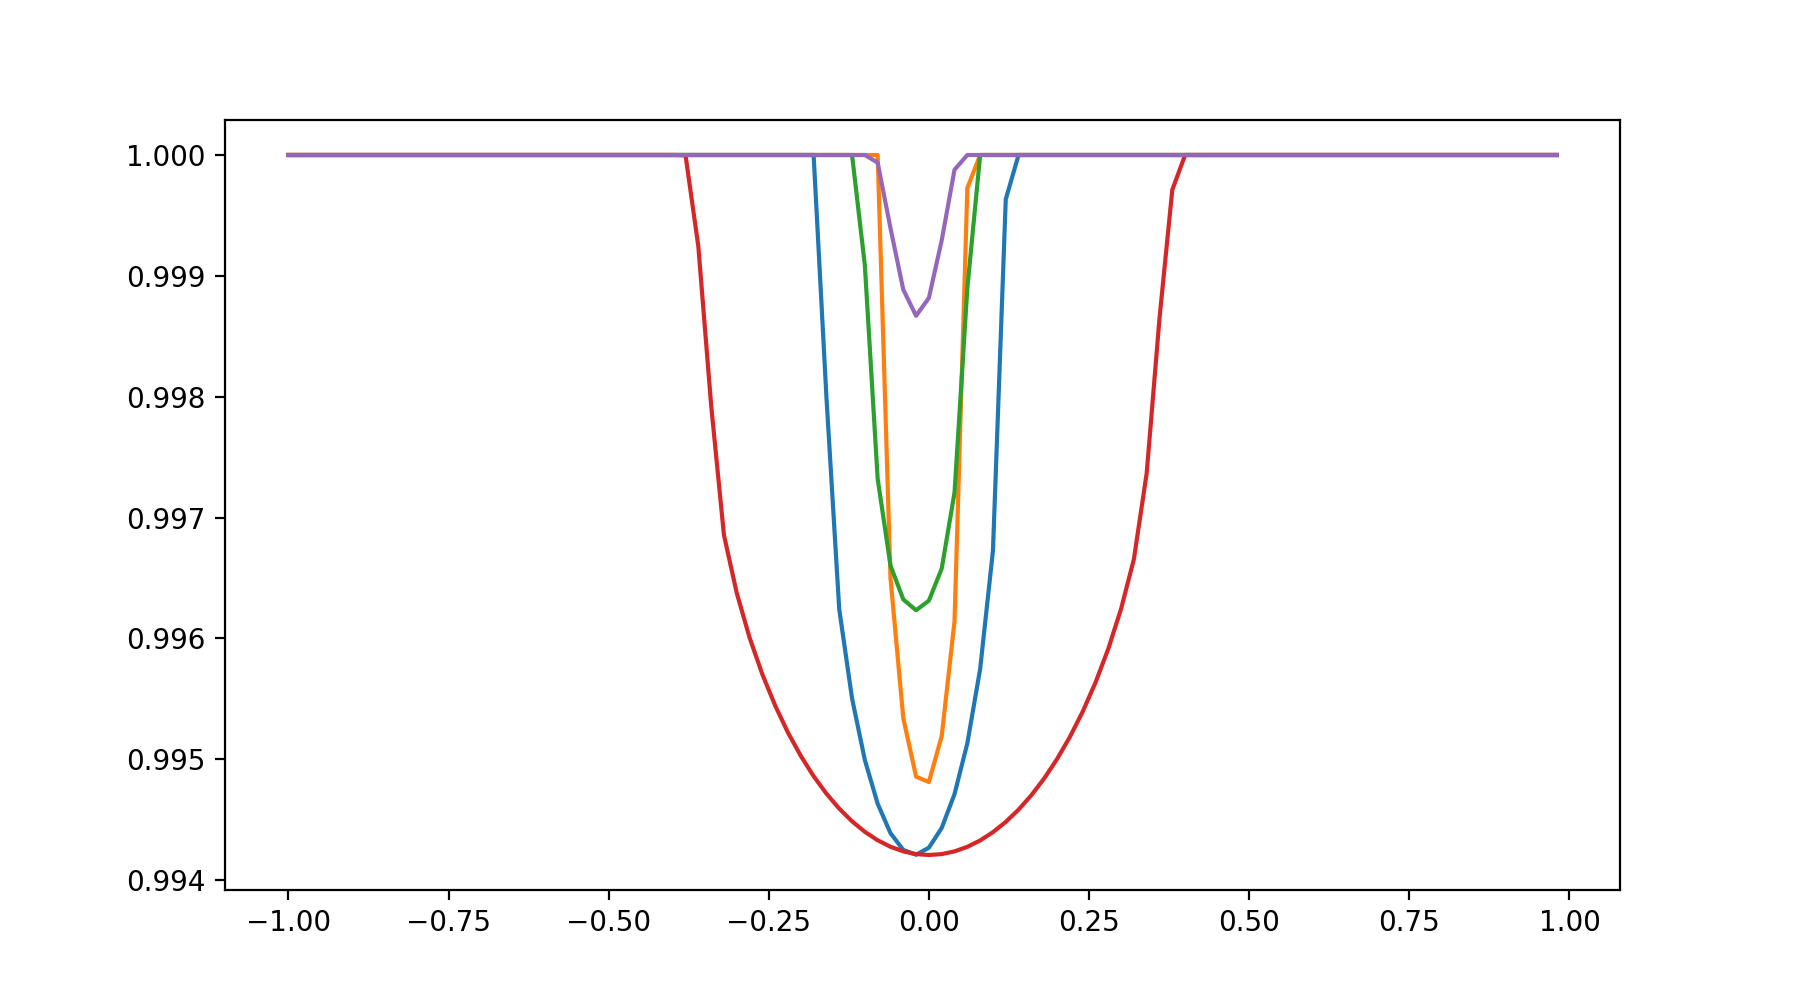

0.00140543969895
[ 2455227.38035758  2455508.31363919  2455789.78219333  2456075.86253494
  2456366.55162156]
[ 2455227.38082189  2455508.31348844  2455789.78155899  2456075.85928388
  2456366.55246815]
[ 0.30109422  0.14015233  0.19219267  0.77160327  0.1319487 ]
[ -1.60755833e-06   5.21933289e-07   2.19624778e-06   1.12559845e-05
  -2.93112007e-06]


In [40]:
# and make the reference stacked light curve set
window = 1.0
#tts = funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))
tts = funcs.reb_cb(cb,tmin=np.min(t),tmax=np.max(t))
tts_2,tds_2 = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
    
ok = tts[:,0] == 20
#ref_tts = tts[ok]
ref_tts = tts_2
ref_stack = ()
#for tt in tts[ok,1]:
for tt in tts_2:
    in_win = (-window < (t-tt)) & ((t-tt) < window)
    ref_stack += (f_ref[in_win],)
    
fig,ax = plt.subplots(figsize=(9,5))
for f in ref_stack:
    ax.plot(np.arange(-window,window,dt),f)
    
null_chi2 = np.sum([(r-1)**2 for r in ref_stack])
print(null_chi2)
print(tts[ok,1])
print(tts_2)
print(tds_2)
print((tts[ok,1]-tts_2)/p_p0)

In [41]:
# log likelihood function, based on timing
def lnlike(par, *args):
    cb, t = args
    #cb.m1, cb.m2, cb.eb, cb.wb, cb.ap, cb.fp, cb.Wp = par
    #totalmass, massratio, p_p, cb.eb, cb.wb, cb.fp, cb.ip, cb.Wp = par
    totalmass, massratio, p_p, cb.ib, cb.fp, cb.ip, cb.Wp, cb.ep, cb.wp = par
    cb.m2 = totalmass / (1 + 1./massratio)
    cb.m1 = totalmass / (1 + massratio)
    cb.ap = ( totalmass * (p_p/365.25)**2 )**(1./3.)
    
    # force binary period to be fixed
    cb.ab = ab0 * ( (cb.m1+cb.m2)/mb0 )**(1/3.)

    try:
        #tts = funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))
        #tts = funcs.reb_cb(cb,tmin=np.min(t),tmax=np.max(t))
        tts,tds = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
        tts = tts[tds>0]
    except:
        return -np.inf

    #ok = tts[:,0] == 20 #primary transits only
    #if np.sum(ok) != len(ref_tts):
    #    return -np.inf
    if len(tts) != len(ref_tts):
        return -np.inf

    # metric based on 1sigma being some fraction of a day/transit
    #dts = tts[ok,1] - ref_tts[:,1]
    dts = tts - ref_tts
    diff = np.sum( (np.abs(dts)/0.1)**2 )
    #print(dts,-0.5*diff)

    return -0.5 * diff

In [43]:
# run emcee to see where we go
nwalkers = 32

#par0 = [cb.m1+cb.m2, cb.m2/cb.m1, p_p0, cb.eb, cb.wb, cb.fp, cb.ip, cb.Wp]
#labels = ['m1+m2','m2/m1','p_p','eb','wb','fp','ip','Wp']
par0 = [cb.m1+cb.m2, cb.m2/cb.m1, p_p0, cb.ib, cb.fp, cb.ip, cb.Wp, cb.ep, cb.wp] #N.B ep limited to <0.05 - some constraint
labels = ['m1+m2','m2/m1','p_p','ib','fp','ip','Wp', 'ep', 'wp']
#par0 = [cb.m1+cb.m2, cb.m2/cb.m1, p_p0, cb.ib, cb.eb, cb.wb, cb.fp, cb.ip, cb.Wp]
#labels = ['m1+m2','m2/m1','p_p','ib','eb','wb','fp','ip','Wp']

npar = len(par0)
par0 = [ par0 + par0*np.random.normal(scale=0.001,size=npar) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, npar, lnlike, args=(copy.deepcopy(cb), t), threads=4 )
pos,lnprob,rstate = sampler.run_mcmc(par0, 3000)

/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: Run

<IPython.core.display.Javascript object>


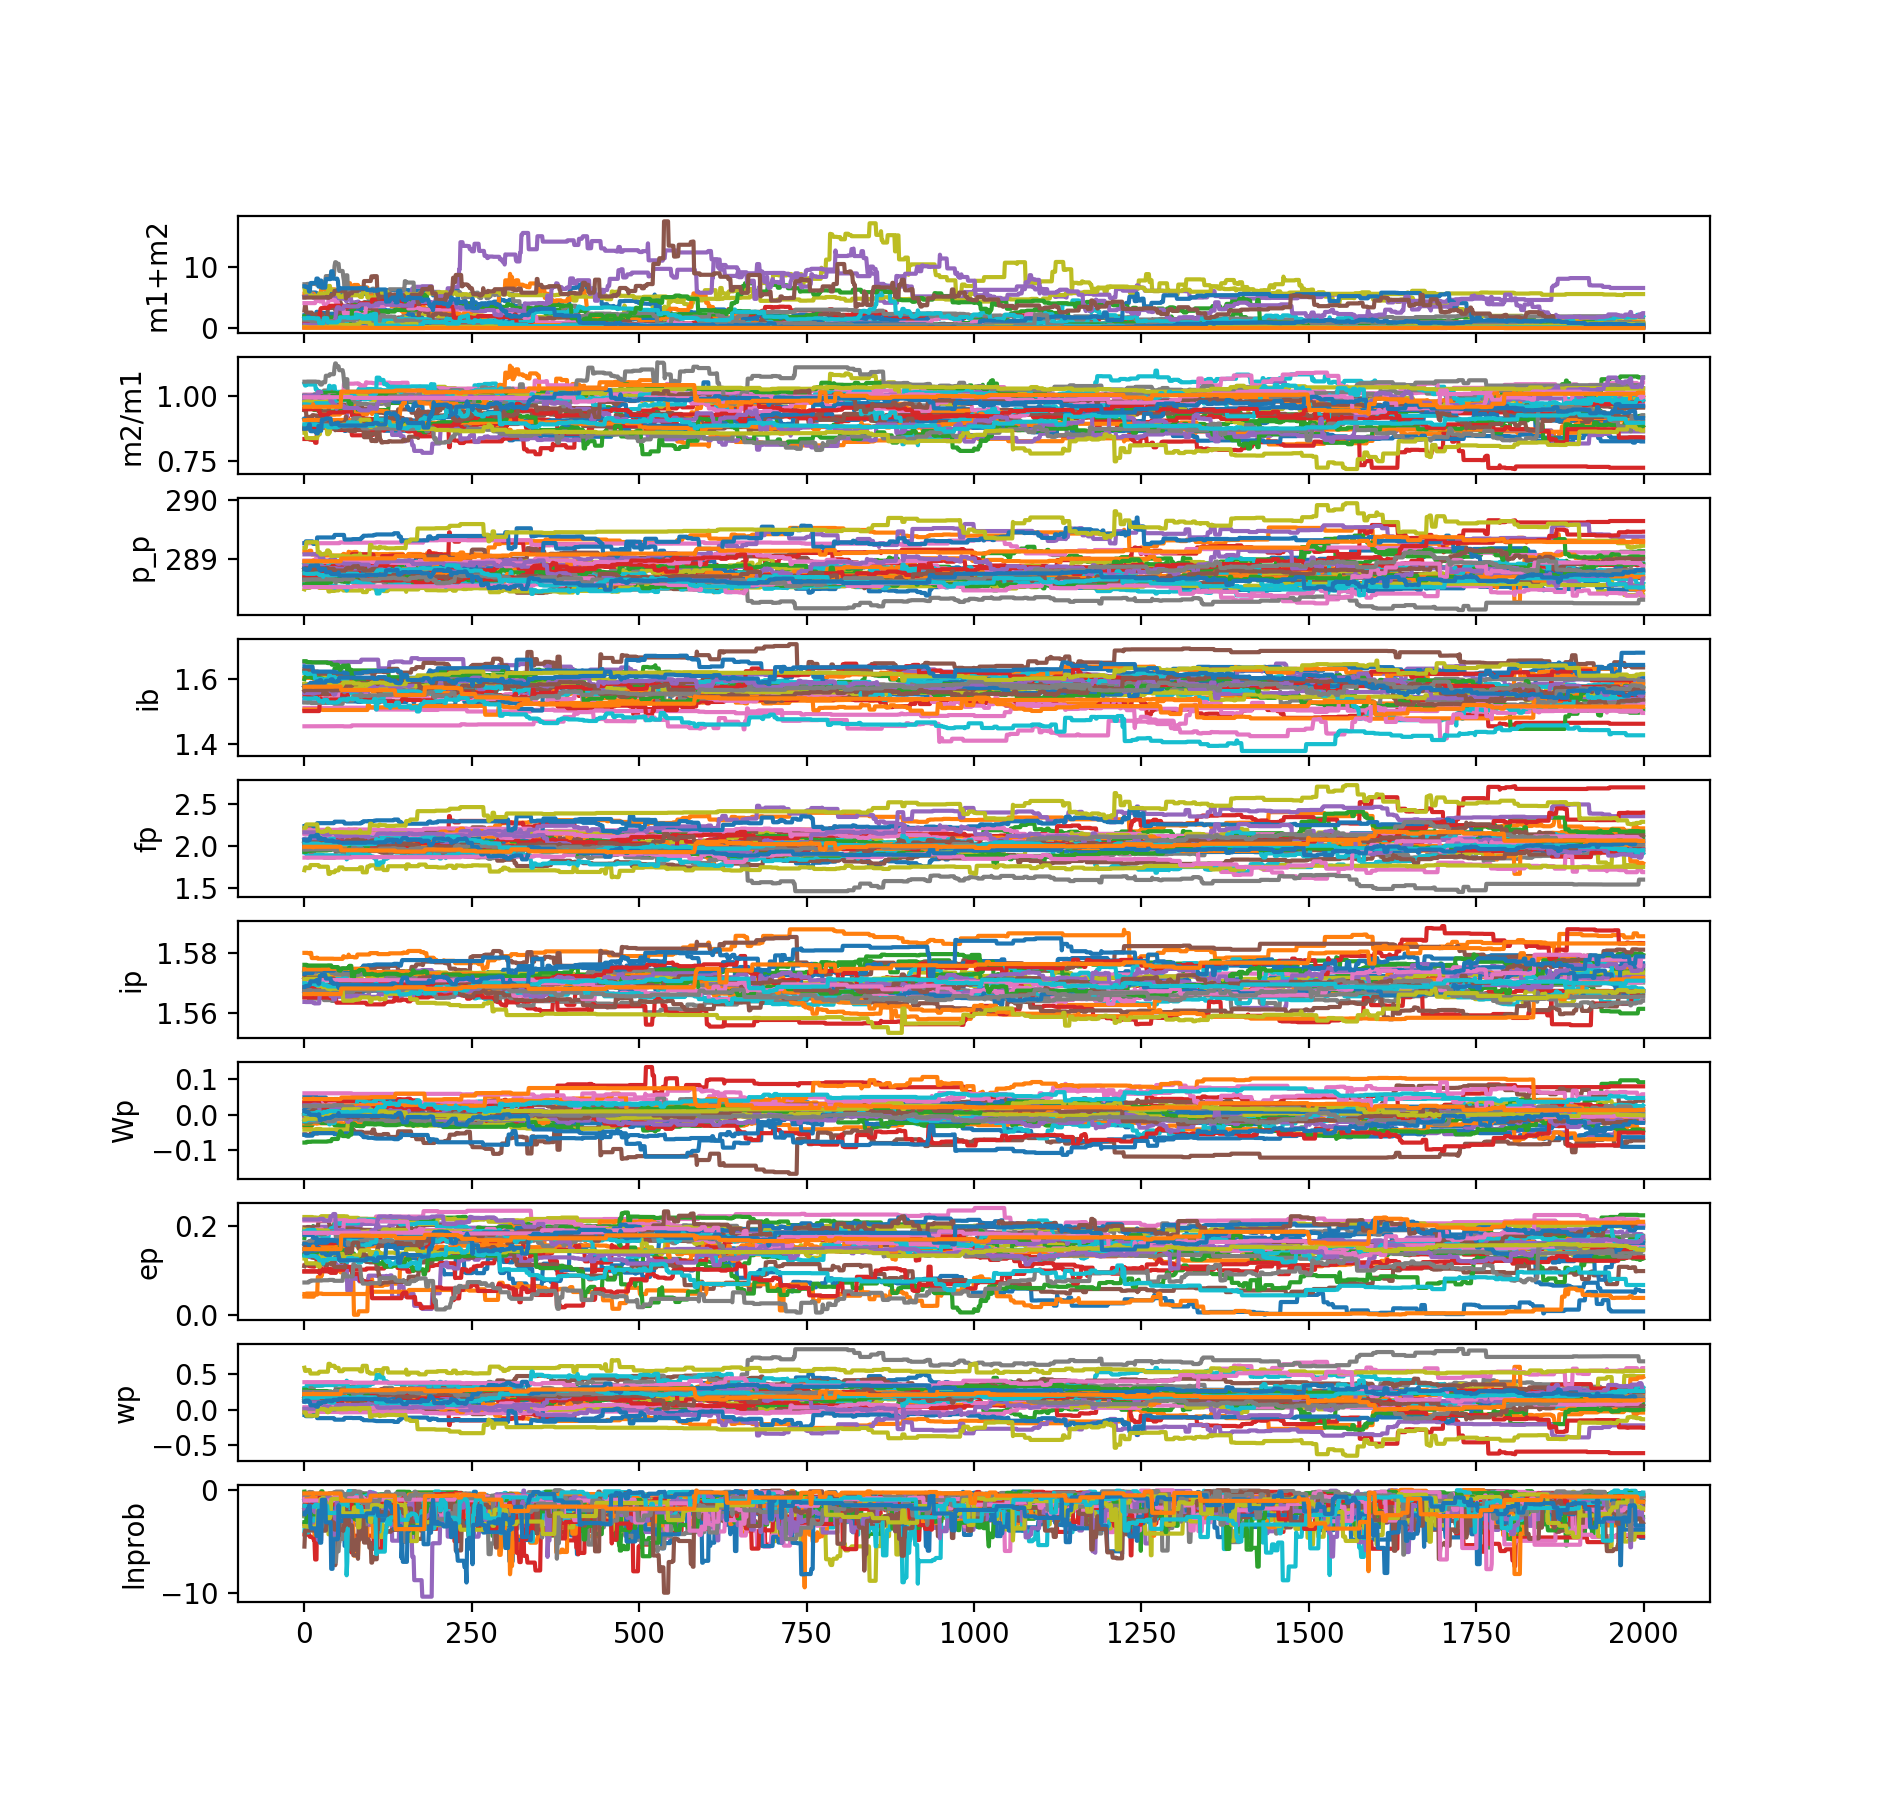

In [44]:
burn_in = 1000
fig,ax = plt.subplots(npar+1,figsize=(9.5,npar),sharex=True)
for j in range(nwalkers):
    ax[npar].plot(sampler.lnprobability[j,burn_in:])
    ax[npar].set_ylabel('lnprob')
    for i in range(npar):
        ax[i].plot(sampler.chain[j,burn_in:,i])
        ax[i].set_ylabel(labels[i])

In [45]:
labels

['m1+m2', 'm2/m1', 'p_p', 'ib', 'fp', 'ip', 'Wp', 'ep', 'wp']

<IPython.core.display.Javascript object>


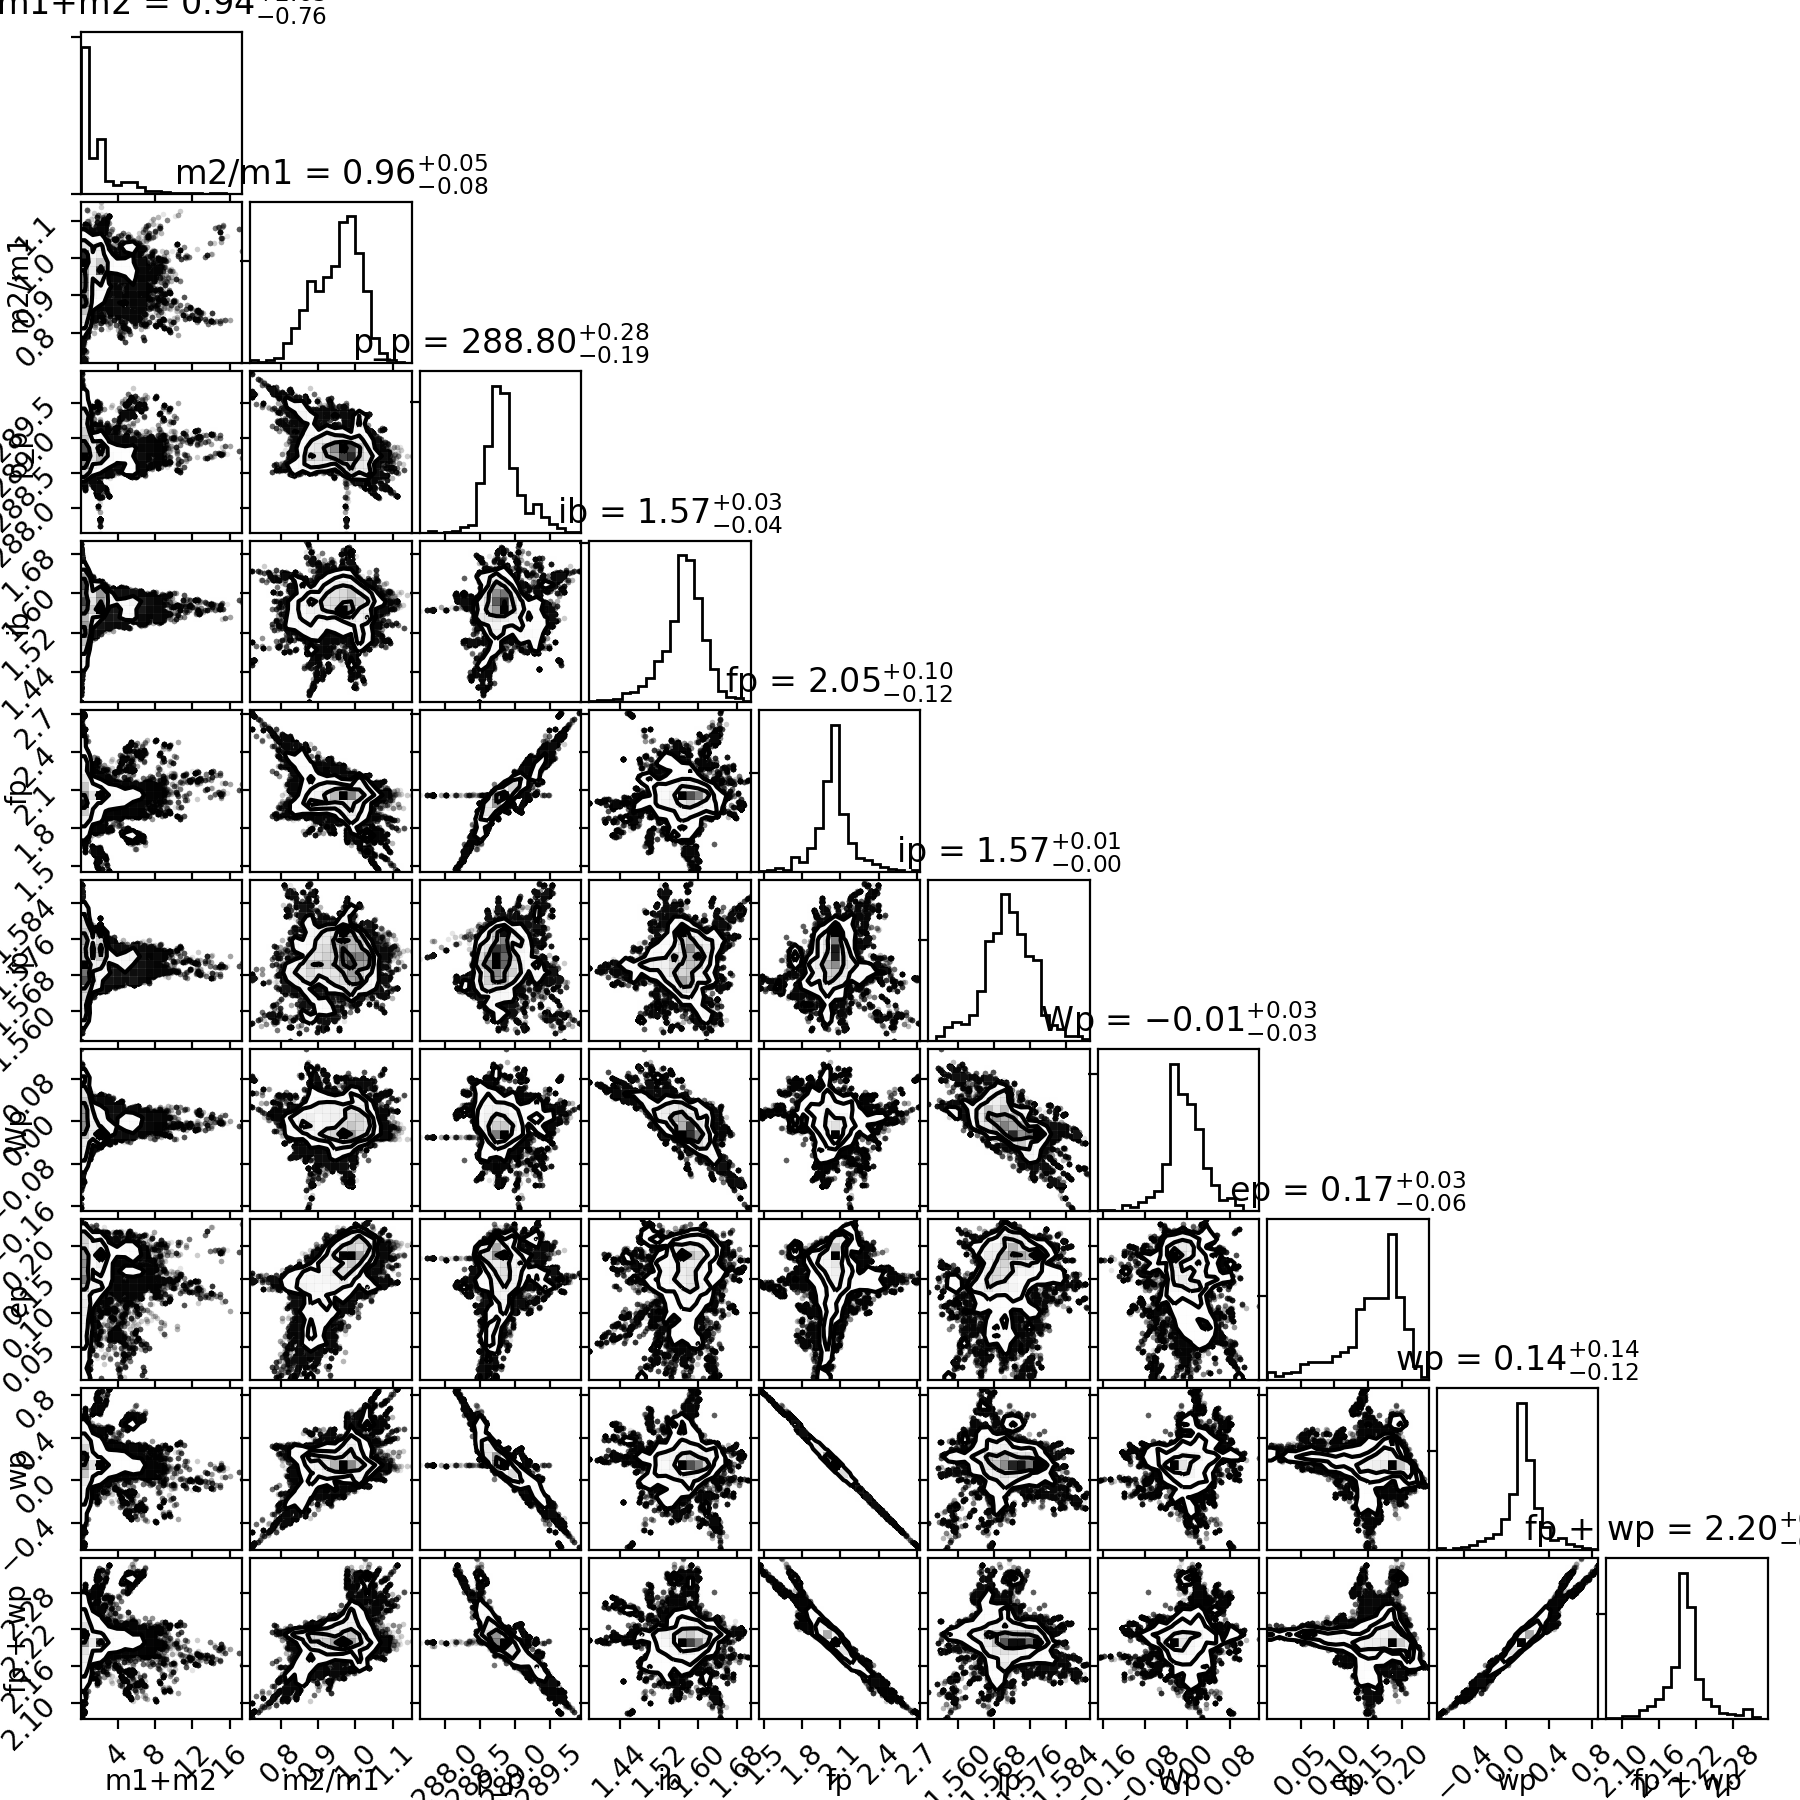

In [47]:
chains = sampler.flatchain[burn_in:]
chains = np.vstack((chains.T,np.mod(chains[:,4]+chains[:,8],2*np.pi))).T
labels += ['fp + wp']
#labels = labels[:-1]
fig,ax = plt.subplots(npar+1,npar+1,figsize=(9,9))
fig = corner.corner(chains,labels=labels,fig=fig,show_titles=True)

In [83]:
cb1 = copy.deepcopy(cb)

fig,ax = plt.subplots(4,4,figsize=(9,6),sharex=True)

for i in range(4):
    for j in range(4):
        
        cb1.m1, cb1.m2, cb1.eb, cb1.wb, cb1.ap, cb1.fp = sampler.chain[4*i+j,-1,:]
        cb1.ab = ab0 * ( (cb1.m1+cb1.m2)/mb0 )**(1/3.)
        tts = funcs.reb_cb(cb1,tmin=np.min(t),tmax=np.max(t))

        ok = tts[:,0] == 20


<IPython.core.display.Javascript object>

ValueError: too many values to unpack (expected 6)